# TGFB Part 2 - Filtering the data
We take the matrix data, run filtering on it and tooling for PCA.

In [1]:
import numpy as np
import pandas
import scanpy
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import scanpy as sc

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

results_file = './write/tgfb1-2.h5ad'  # the file that will store the analysis results

adata = anndata.read("./write/tgfb1-1.h5ad")

/home/ubuntu/.local/lib/python3.6/site-packages/numba/errors.py:105: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


scanpy==1.4 anndata==0.6.18 numpy==1.16.2 scipy==1.2.1 pandas==0.24.2 scikit-learn==0.20.3 statsmodels==0.9.0 


## Preprocessing

Show those genes that yield the highest fraction of counts in each single cells, across all cells.

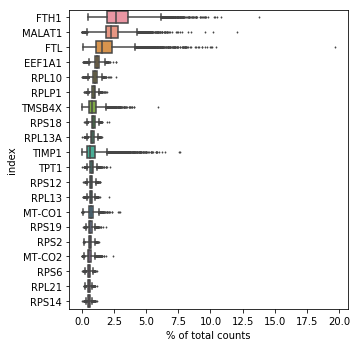

In [2]:
sc.pl.highest_expr_genes(adata, n_top=20)

Basic filtering.

In [3]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 13748 genes that are detected in less than 3 cells


Let us assemple some information about mitochondrial genes, which are important for quality control.

Citing from "Simple Single Cell" workflows [(Lun, McCarthy & Marioni, 2017)](https://master.bioconductor.org/packages/release/workflows/html/simpleSingleCell.html#examining-gene-level-metrics):

> High proportions are indicative of poor-quality cells (Islam et al. 2014; Ilicic et al. 2016), possibly because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane.

Note you can also use the function `pp.calculate_qc_metrics` to compute the fraction of mitochondrial genes and additional measures.

In [4]:
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
# IS THERE A WAY TO DO THIS BY BATCH TO PROVE THAT BOTH BATCHES HAVE SIMILAR PRECENT.MITO VALUES?
adata.obs['percent_mito'] = np.ravel(np.sum(
    adata[:, mito_genes].X, axis=1)) / np.ravel(np.sum(adata.X, axis=1))
# add the total counts per cell as observations-annotation to adata
# AS ABOVE - PRESENT BY BATCH?
adata.obs['n_counts'] = np.ravel(adata.X.sum(axis=1))

In [5]:
[i for i in mito_genes if i is True]

[]

In [6]:
np.sum(adata[:, mito_genes].X, axis=1)

ArrayView([401., 852., 351., ..., 583., 248., 288.], dtype=float32)

In [7]:
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.ravel(np.sum(
    adata[:, mito_genes].X, axis=1)) / np.ravel(np.sum(adata.X, axis=1))
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = np.ravel(adata.X.sum(axis=1))

A violin plot of the computed quality measures.

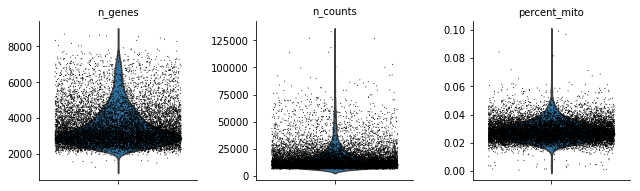

In [8]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

Remove cells that have too many mitochondrial genes expressed or too many total counts.

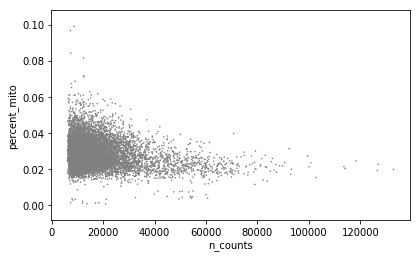

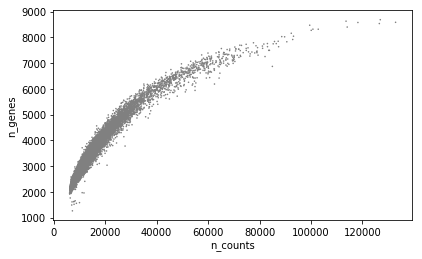

In [9]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [10]:
adata

AnnData object with n_obs × n_vars = 12318 × 19946 
    obs: 'batch', 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_names', 'gene_ids', 'n_cells'

Actually do the filtering.

In [11]:
adata = adata[adata.obs['n_genes'] < 100000, :]
adata = adata[adata.obs['percent_mito'] < 0.05, :]

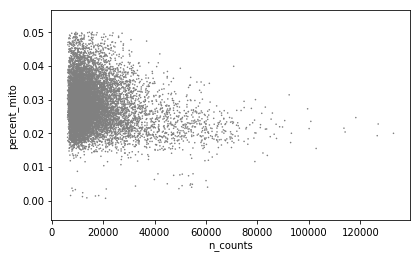

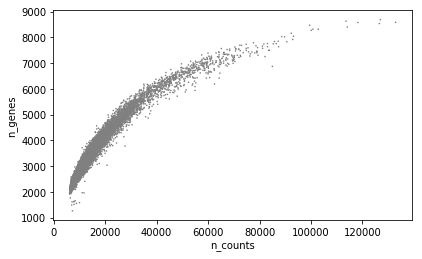

In [12]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [13]:
adata

AnnData object with n_obs × n_vars = 12220 × 19946 
    obs: 'batch', 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_names', 'gene_ids', 'n_cells'

Total-count normalize (library-size correct) the data matrix $\mathbf{X}$ to 10,000 reads per cell, so that counts become comparable among cells.

In [14]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

Logarithmize the data.

In [15]:
sc.pp.log1p(adata)

Set the `.raw` attribute of AnnData object to the logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object. While many people consider the normalized data matrix as the "relevant data" for visualization and differential testing, some would prefer to store the unnormalized data.

In [16]:
# Eats up too much memory!
# adata.raw = adata

Identify highly-variable genes.

In [17]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


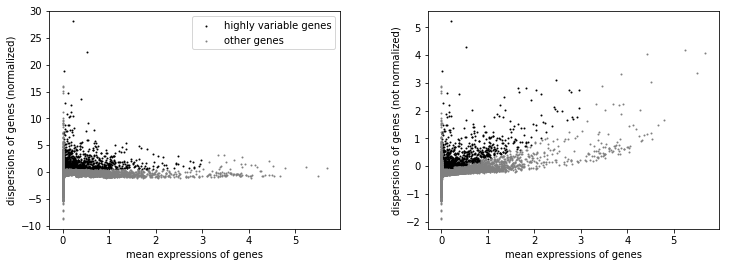

In [18]:
sc.pl.highly_variable_genes(adata)

In [19]:
import collections

In [20]:
collections.Counter(adata.var["highly_variable"])

Counter({False: 18600, True: 1346})

# Filter out highly variable genes

In [21]:
adata = adata[:, adata.var['highly_variable']]

In [22]:
adata

View of AnnData object with n_obs × n_vars = 12220 × 1346 
    obs: 'batch', 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_names', 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'

Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.

# Regress out counts

In [23]:
sc.pp.regress_out(adata, ['n_counts'])

regressing out ['n_counts']
    finished (0:00:09.19)


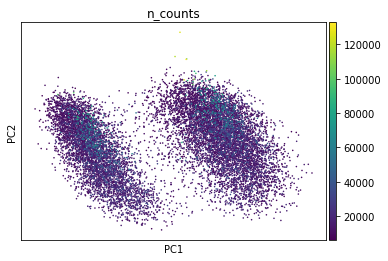

In [24]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata, color='n_counts')

# Scale each gene to unit variance. Clip values exceeding standard deviation 10. 

In [25]:
sc.pp.scale(adata, max_value=10)

# Run principal component analysis

Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

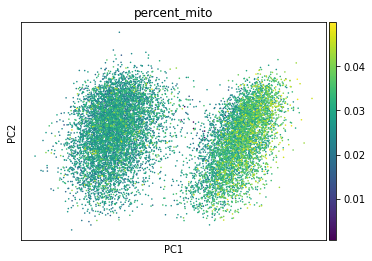

In [26]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata, color='percent_mito')

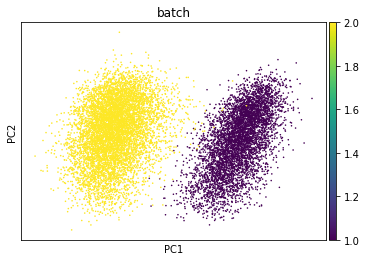

In [27]:
sc.pl.pca(adata, color='batch')

# Save filtered matrix

In [28]:
adata

AnnData object with n_obs × n_vars = 12220 × 1346 
    obs: 'batch', 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_names', 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [29]:
adata.write(results_file)